In [1]:
"""
Epipolar Constraints for Self-Supervised Keypoint Detection

@author: Ganesh Sistu
"""
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt

# Use any pair of images captured from the same camera with an unknown
# transformation matrix R/t (will be calculated as part of the essential matrix)

# K = np.array([[391.469, 0, 192],
#               [0, 342.976, 112],
#               [0, 0, 1]])

# img1 = cv2.imread('DSCF4668.JPG')
# img2 = cv2.imread('DSCF4669.JPG')
# # Resize images
# dim = (384, 224)
# image1 = cv2.resize(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB), dim)
# image2 = cv2.resize(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB), dim)

In [2]:
# Camera calibration and distortion parameters (OpenCV) kitti-odometry-grayscale dataset
# Camera.fx: 707.0912
# Camera.fy: 707.0912
# Camera.cx: 601.8873
# Camera.cy: 183.1104

# Camera.k1: 0.0
# Camera.k2: 0.0
# Camera.p1: 0.0
# Camera.p2: 0.0

K = np.array([[707.0912, 0, 601.8873],
              [0, 707.0912, 183.1104],
              [0, 0, 1]])

In [3]:
import glob
image_0_path_list = glob.glob('/spslam/kitti-odometry-gray/sequences/07/image_0/*')
print(image_0_path_list[1001])
image_1_path_list = glob.glob('/spslam/kitti-odometry-gray/sequences/07/image_1/*')
print(image_1_path_list[1001])

img1 = cv2.imread(image_0_path_list[0], cv2.IMREAD_UNCHANGED)
img2 = cv2.imread(image_1_path_list[0], cv2.IMREAD_UNCHANGED)

img1_list = []
img2_list = []

# Resize images
dim = (384, 224)
image1 = cv2.resize(img1, dim)
image2 = cv2.resize(img2, dim)

for i in range(len(image_0_path_list)):
    img1_list.append(cv2.imread(image_0_path_list[i], cv2.IMREAD_UNCHANGED))
    img2_list.append(cv2.imread(image_1_path_list[i], cv2.IMREAD_UNCHANGED))

/spslam/kitti-odometry-gray/sequences/07/image_0/000631.png
/spslam/kitti-odometry-gray/sequences/07/image_1/000631.png


In [4]:
def find_essential_matrix(img1, img2, K):
    # Convert images to grayscale
#     gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
#     gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    gray1 = img1
    gray2 = img2
    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

    # FLANN parameters and matcher
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    # Filter matches using the Lowe's ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good.append(m)
# #     Draw the good matches
#     img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, good, None, flags=2)
#     plt.imshow(img_matches)
#     plt.axis('off')  # Turn off axis numbers
#     plt.show()
    # Minimum number of matches
    MIN_MATCH_COUNT = 10
    if len(good) > MIN_MATCH_COUNT:
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

        # Compute the Essential Matrix
        E, mask = cv2.findEssentialMat(src_pts, dst_pts, K)
        return E
    else:
        print(f"Not enough matches are found - {len(good)}/{MIN_MATCH_COUNT}")
        return None

# find the essential matrix
essential_matrix = find_essential_matrix(image1, image2, K)
print("Essential Matrix:\n", essential_matrix)


Essential Matrix:
 [[-3.94597560e-04 -2.54632175e-01 -8.71685430e-03]
 [ 2.71194520e-01 -3.55174904e-04 -6.52977317e-01]
 [ 1.01857285e-02  6.59588001e-01  5.16307253e-04]]


In [5]:
image1 = (image1.astype('float32') / 255.)
image2 = (image2.astype('float32') / 255.)

In [6]:
from superpoint import SuperPoint
config = {
        'superpoint': {
            'nms_radius': 4,
            'keypoint_threshold': 0.005,
            'max_keypoints': -1
        }
}

In [7]:
import torch
import torch.nn.functional as F
from torchvision import models

# class KpPostProcess(torch.nn.Module):

#     def __init__(self, grid_size, scale_factor):
#         super(KpPostProcess, self).__init__()
#         self.scale_factor = scale_factor
#         self.grid_size = grid_size

#     def forward(self, features):
#         batch_size, channels, height, width = features.size()
#         # Generate grid indices
#         h_indices = torch.arange(0, height, grid_size)
#         w_indices = torch.arange(0, width, grid_size)
#         h_grid, w_grid = torch.meshgrid(h_indices, w_indices, indexing='ij')
#         grid_indices = torch.stack([h_grid, w_grid], dim=-1).reshape(-1, 2)  # Shape: [num_grids, 2]
#         # Initialize keypoints and descriptors
#         num_grids = grid_indices.shape[0]
#         keypoints = torch.zeros((batch_size, num_grids, 2)).float()
#         keypoints_probs = torch.zeros((batch_size, num_grids, 1)).float()

#         descriptors = torch.zeros((batch_size, num_grids, channels))

#         # Reshape features for batch processing
#         features_reshaped = features.view(batch_size, channels, -1)  # Shape: [batch_size, channels, H*W]

#         # Process each grid cell
#         for i, (h, w) in enumerate(grid_indices):
#             grid = features[:, :, h:h+grid_size, w:w+grid_size]
#             grid_flat = grid.reshape(batch_size, channels, -1)  # Flatten the grid
#             grid_mean = grid_flat.mean(dim=1)  # does this mean taking average of features?

#             # Compute keypoint probabilities and get max indices
#             keypoint_probs = F.softmax(grid_mean, dim=1)
#             max_idxs = keypoint_probs.argmax(dim=1,keepdim=True)
#             # Calculate (x, y) coordinates of keypoints
#             y_coords = (h + max_idxs // grid_size).float() * scale_factor
#             x_coords = (w + max_idxs % grid_size).float() * scale_factor
#             keypoints[:, i, :] = torch.stack([y_coords, x_coords], dim=1)[:,:,0]
#             keypoints_probs[:, i, :] = keypoint_probs.max(dim=1,keepdim=True).values
#             # Extract descriptors
#             row = max_idxs // grid_size
#             col = max_idxs % grid_size
#             descriptors[:,i, :] = grid[:, :, row, col][:, :, 0, 0]

#         return keypoints, descriptors, keypoints_probs

class KpFeatures(torch.nn.Module):

    def __init__(self):#, grid_size, scale_factor):
        super(KpFeatures, self).__init__()
#         # Instantiate ResNet-18 without the final fully connected layer
#         resnet18 = models.resnet18(pretrained=True)
#         self.resnet18 = torch.nn.Sequential(*list(resnet18.children())[:-2])
#         self.deconv1 = torch.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
#         self.deconv2 = torch.nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
#         self.batch_norm = torch.nn.BatchNorm2d(256)
        self.model = SuperPoint(config)
#         self.post_process = KpPostProcess(grid_size, scale_factor)
    def forward(self, x):
#         # feature extractor
#         x = self.resnet18(x)
#         x = self.deconv1(x)
#         x = self.batch_norm(x)
#         x = self.deconv2(x)
#         # keypoint extraction
#         keypoints, descriptors, keypoints_probs = self.post_process(x)
        x = self.model(x)
#         keypoints, descriptors, keypoints_probs = self.post_process(x['descriptors'])
#         return keypoints, descriptors, keypoints_probs
        return torch.stack(x['keypoints']), torch.transpose(torch.stack(
            x['descriptors']), 1, 2), torch.stack(x['scores']).unsqueeze(dim = 2)


def normalize_keypoints(points, K_inv):
    """
    Normalize keypoints using the inverse camera intrinsic matrix.
    Assumes points are in the shape [batch_size, num_points, 2]
    K_inv is assumed to be [3, 3]
    """
    batch_size, num_points, _ = points.shape

    # Convert to homogeneous coordinates [batch_size, num_points, 3]
    ones = torch.ones(batch_size, num_points, 1, device=points.device)
    homogeneous_points = torch.cat([points, ones], dim=2)

    # Apply K_inv to each point
    # Reshape K_inv to broadcast across the batch
    K_inv_batch = K_inv.unsqueeze(0).repeat(batch_size, 1, 1)

    # Batch matrix multiplication
    normalized_points = torch.bmm(homogeneous_points, K_inv_batch.transpose(1, 2))

    return normalized_points


def sinkhorn_iterations(scores, max_iterations=20, epsilon=1e-3):
    # Apply Sinkhorn iterations for each element in the batch
    for _ in range(max_iterations):
        # Row normalization - ensure normalization is done for each batch separately
        scores = torch.nn.functional.softmax(scores, dim=2)

        # Column normalization - again, separate for each batch
        scores = torch.nn.functional.softmax(scores, dim=1)
    return scores

def contrastive_loss(desc1, desc2, soft_assignment, margin=1.0):
    batch_size, num_points, _ = desc1.shape

    # Calculate the pairwise distance matrix for each batch
    pairwise_distances = torch.cdist(desc1, desc2, p=2)  # Shape: [batch_size, num_points, num_points]

    # Positive pairs: Use soft_assignment as weights for the distances
    positive_loss = torch.sum(soft_assignment * pairwise_distances) / batch_size

    # Negative pairs: Push apart pairs with low assignment probability
    negative_loss = torch.sum((1 - soft_assignment) * torch.clamp(margin - pairwise_distances, min=0)) / batch_size

    loss = positive_loss + 0.5 * negative_loss
    loss = loss/num_points
    return loss


def sampson_distance(points1, points2, E):
    """
    Compute the Sampson distance for batched points and a single Essential Matrix.
    Assumes points1 and points2 are normalized and in homogeneous coordinates,
    with shape [batch_size, total_points, 3].
    E is the Essential Matrix with shape [3, 3].
    """
    # Ensure E is transposed correctly for batch matrix multiplication
    E_transposed = E.transpose(0, 1)  # Should be [3, 3]

    # Apply Essential Matrix to the points
    Fx1 = torch.bmm(points1, E_transposed.unsqueeze(0).repeat(points1.size(0), 1, 1))  # [batch_size, total_points, 3]
    Fx2 = torch.bmm(points2, E.unsqueeze(0).repeat(points2.size(0), 1, 1))             # [batch_size, total_points, 3]

    # Compute the error terms
    errors = (points2 * Fx1).sum(dim=2)  # [batch_size, total_points]

    # Compute the denominator
    denom = Fx1[:, :, 0]**2 + Fx1[:, :, 1]**2 + Fx2[:, :, 0]**2 + Fx2[:, :, 1]**2  # [batch_size, total_points]

    # Compute the Sampson distance
    sampson_dist = (errors**2 / denom).sum(dim=1)  # Sum over points, [batch_size]

    return sampson_dist  # Returns a tensor of shape [batch_size]

descriptor_loss_list = []
geometric_loss_list = []

def ep_loss(desc1, desc2, points1, points2, K, E, alpha, margin=1.0):
    # Descriptor similarity (Euclidean distance as an example)
    desc_distance = torch.cdist(desc1, desc2)
#     print('desc_distance', desc_distance.shape)
    desc_similarity = torch.nn.functional.softmax(-desc_distance, dim=2)
#     print('desc_similarity', desc_similarity.shape)
    soft_assignment = torch.softmax(desc_similarity, dim=1) 
    # size of soft assignment is changing in every epoch because it depends on number of descriptors
    print('soft_assignment', soft_assignment.shape)
    match_indices = torch.argmax(soft_assignment, dim=2)
    
	# Create a range tensor for batch indexing
    batch_indices = torch.arange(points2.size(0)).unsqueeze(1)
    # Use torch.gather to align points2 according to match_indices
    aligned_points2 = torch.gather(points2, 1, match_indices.unsqueeze(-1).expand(-1, -1, points2.size(-1)))
    # Normalize keypoints
    K_inv = torch.inverse(K)  # Inverse of camera intrinsic matrix
    normalized_points1 = normalize_keypoints(points1, K_inv)
    normalized_aligned_points2 = normalize_keypoints(aligned_points2, K_inv)
#     print(normalized_points1.shape, normalized_aligned_points2.shape)
    # Step 3: Calculate Sampson Distance for Geometric Loss
    geometric_loss = sampson_distance(normalized_points1, normalized_aligned_points2, E)

    # Descriptor loss (can be based on soft_assignment)
    descriptor_loss = contrastive_loss(desc1, desc2, soft_assignment, margin=1.0)

    # Combined loss
    descriptor_loss_list.append(descriptor_loss.item())
    geometric_loss_list.append(geometric_loss.item())
    combined_loss = alpha * descriptor_loss + (1 - alpha) * geometric_loss

    return combined_loss

# Function to move tensor to GPU if available
def move_to_gpu(tensor):
    if torch.cuda.is_available():
        tensor = tensor.cuda()
    return tensor

# Function to convert a tensor to a numpy array
def tensor_to_numpy(tensor):
    # Move tensor to cpu first if it's on GPU
    if tensor.is_cuda:
        tensor = tensor.cpu()
    return tensor.numpy()


def filter_and_pad_points(prob_tensor, tensor1, tensor2, thresh=0.3, pad_value=0):
    """
    Filters the points in tensor1 and tensor2 across all batches at once based on the
    probability score threshold in prob_tensor, and pads the results to ensure equal size.
    """
#     print('prob_tensor:', prob_tensor.shape)
#     print('tensor1:', tensor1.shape)
#     print('tensor2:', tensor2.shape)
    batch_size, total_points, _ = prob_tensor.shape

    # Initialize lists to store filtered results
    filtered_tensor1_list = []
    filtered_tensor2_list = []

    # Filter each batch separately
    for b in range(batch_size):
        mask = prob_tensor[b, :, 0] > thresh
        filtered_tensor1_list.append(tensor1[b, mask].unsqueeze(0))  # Add a new dimension
        filtered_tensor2_list.append(tensor2[b, mask].unsqueeze(0))  # Add a new dimension

    # Concatenate the filtered results along a new dimension
    concatenated_tensor1 = torch.cat(filtered_tensor1_list, dim=0)
    concatenated_tensor2 = torch.cat(filtered_tensor2_list, dim=0)

    return concatenated_tensor1, concatenated_tensor2

In [8]:
# Define grid size and scale factor
grid_size = 3 # change based on the image encoder
scale_factor = 8 # depends on the image encoder

# pytorch data preparation
# opencv_image1 = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
# opencv_image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)
opencv_image11 = np.expand_dims(image1, axis = 0)
opencv_image22 = np.expand_dims(image2, axis = 0)
# # Rearrange the axes to [C, H, W]
# opencv_image1 = np.transpose(image1, (2, 0, 1))
# Convert to a float tensor
input1 = torch.unsqueeze(torch.from_numpy(opencv_image11).float(), dim=0)
# input1 = torch.unsqueeze(input1, dim = 0)

# # Rearrange the axes to [C, H, W]
# opencv_image2 = np.transpose(image2, (2, 0, 1))
# Convert to a float tensor
input2 = torch.unsqueeze(torch.from_numpy(opencv_image22).float(), dim=0)
# input2 = torch.unsqueeze(input2, dim = 0)

In [9]:
# kp_net = KpFeatures(grid_size, scale_factor)
kp_net = KpFeatures()
move_to_gpu(kp_net)
learning_rate = 1e-5
optimizer = torch.optim.RMSprop(kp_net.parameters(), lr=learning_rate)

Loaded SuperPoint model


In [10]:
def convert_keypoints(keypoints_array, size=1.0):
    """Converts numpy array keypoints to a list of cv2.KeyPoint objects."""
    return [cv2.KeyPoint(x=float(kp[0]), y=float(kp[1]), size=size) for kp in keypoints_array.reshape(-1, 2)]


kp_net.eval()

with torch.no_grad():
    kp_1, d_1, kp_prob1 = kp_net(move_to_gpu(input1))
    kp_2, d_2, kp_prob2 = kp_net(move_to_gpu(input2))

    
# print(kp_1.shape)
# print(kp_2.shape)

kp_1, d_1 = filter_and_pad_points(kp_prob1, kp_1, d_1, 0)
kp_2, d_2 = filter_and_pad_points(kp_prob2, kp_2, d_2, 0)

print(kp_1.shape)
print(kp_2.shape)

infer_keypoints1 = kp_1.detach().cpu().numpy()
infer_keypoints2 = kp_2.detach().cpu().numpy()

# Convert numpy array keypoints to list of cv2.KeyPoint objects
keypoints1 = convert_keypoints(infer_keypoints1)
keypoints2 = convert_keypoints(infer_keypoints2)

# Create a BFMatcher object
# Choose the appropriate norm type depending on your descriptor
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match descriptors
matches = bf.match( tensor_to_numpy(d_1).reshape(-1, 256), tensor_to_numpy(d_2).reshape(-1, 256))
# print('matches:', matches[0])
# print('keypoints1:', keypoints1)
# print('keypoints2:', keypoints2)
# Apply Lowe's ratio
ratio_threshold = 0.75  # Can be adjusted, common values are in the range 0.7 to 0.8
# good_matches = [m for m, n in matches if m.distance < ratio_threshold * n.distance]

# Draw the top N matches
try:
    img_matches = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches, None, flags=2)
except:
    print("****************** ERROR DUE TO RANDOM MATCHES: TRY AFTER 10 EPOCHS ********************")

# Display the image
plt.imshow(img_matches)
plt.axis('off')  # Turn off axis numbers
plt.show()


torch.Size([1, 303, 2])
torch.Size([1, 311, 2])
****************** ERROR DUE TO RANDOM MATCHES: TRY AFTER 10 EPOCHS ********************


NameError: name 'img_matches' is not defined

In [11]:
kp_net.train()
for i in range(1):
    for j in range(len(img1_list)):
        image1 = img1_list[j]
        image2 = img2_list[j]
        img1 = cv2.resize(image1, dim)
        img2 = cv2.resize(image2, dim)
        
        K = np.array([[707.0912, 0, 601.8873],
              [0, 707.0912, 183.1104],
              [0, 0, 1]])        
        essential_matrix = find_essential_matrix(img1, img2, K)
        
        img1 = (img1.astype('float32') / 255.)
        img2 = (img2.astype('float32') / 255.)
        
        opencv_image11 = np.expand_dims(img1, axis = 0)
        opencv_image22 = np.expand_dims(img2, axis = 0)
        
        
        # Convert to a float tensor
        input1 = torch.unsqueeze(torch.from_numpy(opencv_image11).float(), dim=0)
        input2 = torch.unsqueeze(torch.from_numpy(opencv_image22).float(), dim=0)        
        
        keypoints1, des1, kp_prob1 = kp_net(move_to_gpu(input1))
        keypoints2, des2, kp_prob2 = kp_net(move_to_gpu(input2))
        
        
        E = torch.from_numpy(essential_matrix).float()
        K = torch.from_numpy(K).float()
        E = E.cuda()
        K = K.cuda()
        optimizer.zero_grad()
        combined_loss = ep_loss(des1, des2, keypoints1, keypoints2, K, E, alpha = 0.5, margin=1.0)
        if i % 1 == 0:
            print("epoch******", i, combined_loss.item())
        combined_loss.backward()
        optimizer.step()

soft_assignment torch.Size([1, 303, 311])
epoch****** 0 1.0041007995605469
soft_assignment torch.Size([1, 290, 281])
epoch****** 0 0.8932145833969116
soft_assignment torch.Size([1, 153, 152])
epoch****** 0 0.9831752181053162
soft_assignment torch.Size([1, 357, 348])
epoch****** 0 0.901386022567749
soft_assignment torch.Size([1, 367, 359])
epoch****** 0 0.9117469787597656
soft_assignment torch.Size([1, 280, 268])
epoch****** 0 0.8809213638305664
soft_assignment torch.Size([1, 404, 407])
epoch****** 0 0.8841606974601746
soft_assignment torch.Size([1, 344, 340])
epoch****** 0 0.9096548557281494
soft_assignment torch.Size([1, 389, 404])
epoch****** 0 0.9371726512908936
soft_assignment torch.Size([1, 336, 333])
epoch****** 0 0.8934909105300903
soft_assignment torch.Size([1, 315, 322])
epoch****** 0 0.9007457494735718
soft_assignment torch.Size([1, 349, 315])
epoch****** 0 0.846107006072998
soft_assignment torch.Size([1, 374, 361])
epoch****** 0 0.8662716150283813
soft_assignment torch.Size(

soft_assignment torch.Size([1, 393, 393])
epoch****** 0 0.9255823493003845
soft_assignment torch.Size([1, 365, 347])
epoch****** 0 0.8230482935905457
soft_assignment torch.Size([1, 338, 345])
epoch****** 0 0.9405114650726318
soft_assignment torch.Size([1, 336, 327])
epoch****** 0 0.8175361156463623
soft_assignment torch.Size([1, 389, 364])
epoch****** 0 0.9025434851646423
soft_assignment torch.Size([1, 288, 270])
epoch****** 0 0.8602002263069153
soft_assignment torch.Size([1, 278, 271])
epoch****** 0 0.869243860244751
soft_assignment torch.Size([1, 230, 234])
epoch****** 0 0.8604494333267212
soft_assignment torch.Size([1, 360, 330])
epoch****** 0 0.8603866100311279
soft_assignment torch.Size([1, 306, 316])
epoch****** 0 0.8468016386032104
soft_assignment torch.Size([1, 322, 316])
epoch****** 0 0.856873631477356
soft_assignment torch.Size([1, 326, 325])
epoch****** 0 0.9787135124206543
soft_assignment torch.Size([1, 327, 325])
epoch****** 0 0.8854295611381531
soft_assignment torch.Size(

soft_assignment torch.Size([1, 214, 178])
epoch****** 0 0.8977189660072327
soft_assignment torch.Size([1, 200, 198])
epoch****** 0 0.8063837289810181
soft_assignment torch.Size([1, 131, 130])
epoch****** 0 0.788692057132721
soft_assignment torch.Size([1, 130, 123])
epoch****** 0 0.7474300265312195
soft_assignment torch.Size([1, 170, 182])
epoch****** 0 0.8958872556686401
soft_assignment torch.Size([1, 146, 143])
epoch****** 0 0.8016469478607178
soft_assignment torch.Size([1, 140, 157])
epoch****** 0 0.910560131072998
soft_assignment torch.Size([1, 183, 193])
epoch****** 0 0.8932099938392639
soft_assignment torch.Size([1, 97, 79])
epoch****** 0 0.6703565716743469
soft_assignment torch.Size([1, 185, 177])
epoch****** 0 0.8958961963653564
soft_assignment torch.Size([1, 232, 226])
epoch****** 0 1.0572805404663086
soft_assignment torch.Size([1, 225, 210])
epoch****** 0 0.7967678308486938
soft_assignment torch.Size([1, 141, 133])
epoch****** 0 0.7606975436210632
soft_assignment torch.Size([1

soft_assignment torch.Size([1, 124, 150])
epoch****** 0 0.9354560375213623
soft_assignment torch.Size([1, 89, 96])
epoch****** 0 0.8224563002586365
soft_assignment torch.Size([1, 125, 111])
epoch****** 0 0.7115262746810913
soft_assignment torch.Size([1, 130, 127])
epoch****** 0 0.7833470106124878
soft_assignment torch.Size([1, 160, 152])
epoch****** 0 0.8582881689071655
soft_assignment torch.Size([1, 154, 153])
epoch****** 0 0.8647832870483398
soft_assignment torch.Size([1, 151, 118])
epoch****** 0 0.6492599844932556
soft_assignment torch.Size([1, 138, 130])
epoch****** 0 0.7627010345458984
soft_assignment torch.Size([1, 127, 126])
epoch****** 0 0.7949749231338501
soft_assignment torch.Size([1, 115, 121])
epoch****** 0 0.80177241563797
soft_assignment torch.Size([1, 66, 75])
epoch****** 0 0.8390498757362366
soft_assignment torch.Size([1, 100, 122])
epoch****** 0 0.9556308388710022
soft_assignment torch.Size([1, 88, 87])
epoch****** 0 0.7346939444541931
soft_assignment torch.Size([1, 72

soft_assignment torch.Size([1, 145, 163])
epoch****** 0 0.9369782209396362
soft_assignment torch.Size([1, 110, 137])
epoch****** 0 0.9593828916549683
soft_assignment torch.Size([1, 139, 154])
epoch****** 0 0.87712562084198
soft_assignment torch.Size([1, 107, 129])
epoch****** 0 0.9287453889846802
soft_assignment torch.Size([1, 121, 123])
epoch****** 0 0.8922855854034424
soft_assignment torch.Size([1, 115, 128])
epoch****** 0 0.8478768467903137
soft_assignment torch.Size([1, 154, 145])
epoch****** 0 0.8660489320755005
soft_assignment torch.Size([1, 110, 114])
epoch****** 0 0.8016882538795471
soft_assignment torch.Size([1, 95, 90])
epoch****** 0 0.7388298511505127
soft_assignment torch.Size([1, 109, 123])
epoch****** 0 0.8207175135612488
soft_assignment torch.Size([1, 143, 150])
epoch****** 0 0.9319562315940857
soft_assignment torch.Size([1, 104, 130])
epoch****** 0 0.9592533111572266
soft_assignment torch.Size([1, 70, 67])
epoch****** 0 0.6898125410079956
soft_assignment torch.Size([1, 

soft_assignment torch.Size([1, 127, 127])
epoch****** 0 0.7998682856559753
soft_assignment torch.Size([1, 114, 133])
epoch****** 0 0.9332243800163269
soft_assignment torch.Size([1, 143, 144])
epoch****** 0 0.7981725931167603
soft_assignment torch.Size([1, 118, 110])
epoch****** 0 0.7284277081489563
soft_assignment torch.Size([1, 100, 96])
epoch****** 0 0.7344168424606323
soft_assignment torch.Size([1, 137, 154])
epoch****** 0 0.9245955348014832
soft_assignment torch.Size([1, 132, 113])
epoch****** 0 0.7149564027786255
soft_assignment torch.Size([1, 100, 99])
epoch****** 0 0.74500972032547
soft_assignment torch.Size([1, 11, 21])
epoch****** 0 1.181825041770935
soft_assignment torch.Size([1, 65, 57])
epoch****** 0 0.6758127212524414
soft_assignment torch.Size([1, 103, 108])
epoch****** 0 0.7547356486320496
soft_assignment torch.Size([1, 142, 128])
epoch****** 0 0.8208357095718384
soft_assignment torch.Size([1, 66, 67])
epoch****** 0 0.7221162915229797
soft_assignment torch.Size([1, 56, 6

soft_assignment torch.Size([1, 112, 101])
epoch****** 0 0.7418091893196106
soft_assignment torch.Size([1, 98, 73])
epoch****** 0 0.6548715829849243
soft_assignment torch.Size([1, 105, 114])
epoch****** 0 0.8642115592956543
soft_assignment torch.Size([1, 134, 136])
epoch****** 0 0.7880954742431641
soft_assignment torch.Size([1, 136, 135])
epoch****** 0 0.9193183183670044
soft_assignment torch.Size([1, 100, 80])
epoch****** 0 0.6667549014091492
soft_assignment torch.Size([1, 24, 22])
epoch****** 0 0.6278198957443237
soft_assignment torch.Size([1, 127, 112])
epoch****** 0 0.7285337448120117
soft_assignment torch.Size([1, 171, 176])
epoch****** 0 0.9289443492889404
soft_assignment torch.Size([1, 165, 173])
epoch****** 0 0.8704947829246521
soft_assignment torch.Size([1, 119, 92])
epoch****** 0 0.7500650882720947
soft_assignment torch.Size([1, 107, 104])
epoch****** 0 0.7538281083106995
soft_assignment torch.Size([1, 129, 133])
epoch****** 0 0.8219236135482788
soft_assignment torch.Size([1, 

soft_assignment torch.Size([1, 129, 124])
epoch****** 0 0.7940043210983276
soft_assignment torch.Size([1, 119, 117])
epoch****** 0 0.8048033714294434
soft_assignment torch.Size([1, 101, 79])
epoch****** 0 0.6858675479888916
soft_assignment torch.Size([1, 101, 86])
epoch****** 0 0.689355731010437
soft_assignment torch.Size([1, 101, 110])
epoch****** 0 0.7831383347511292
soft_assignment torch.Size([1, 103, 154])
epoch****** 0 1.0601507425308228
soft_assignment torch.Size([1, 127, 145])
epoch****** 0 0.9067298769950867
soft_assignment torch.Size([1, 115, 130])
epoch****** 0 0.9244260191917419
soft_assignment torch.Size([1, 87, 67])
epoch****** 0 0.5870966911315918
soft_assignment torch.Size([1, 138, 151])
epoch****** 0 0.9376215934753418
soft_assignment torch.Size([1, 99, 76])
epoch****** 0 0.6976701021194458
soft_assignment torch.Size([1, 154, 150])
epoch****** 0 0.8593866229057312
soft_assignment torch.Size([1, 99, 99])
epoch****** 0 0.796901524066925
soft_assignment torch.Size([1, 118,

soft_assignment torch.Size([1, 72, 71])
epoch****** 0 0.7802367806434631
soft_assignment torch.Size([1, 72, 72])
epoch****** 0 0.7245379090309143
soft_assignment torch.Size([1, 86, 105])
epoch****** 0 0.9191176891326904
soft_assignment torch.Size([1, 94, 112])
epoch****** 0 0.8769757747650146
soft_assignment torch.Size([1, 143, 132])
epoch****** 0 0.9110934138298035
soft_assignment torch.Size([1, 164, 136])
epoch****** 0 0.8035326600074768
soft_assignment torch.Size([1, 121, 114])
epoch****** 0 0.8157476186752319
soft_assignment torch.Size([1, 98, 79])
epoch****** 0 0.6848914623260498
soft_assignment torch.Size([1, 91, 73])
epoch****** 0 0.6863217949867249
soft_assignment torch.Size([1, 122, 90])
epoch****** 0 0.6851857900619507
soft_assignment torch.Size([1, 142, 149])
epoch****** 0 0.8969534635543823
soft_assignment torch.Size([1, 75, 106])
epoch****** 0 0.991134762763977
soft_assignment torch.Size([1, 53, 68])
epoch****** 0 0.8368731737136841
soft_assignment torch.Size([1, 87, 66])


soft_assignment torch.Size([1, 105, 100])
epoch****** 0 0.7887170910835266
soft_assignment torch.Size([1, 95, 116])
epoch****** 0 0.936018705368042
soft_assignment torch.Size([1, 76, 93])
epoch****** 0 0.8496458530426025
soft_assignment torch.Size([1, 121, 89])
epoch****** 0 0.6205692887306213
soft_assignment torch.Size([1, 89, 90])
epoch****** 0 0.7673186659812927
soft_assignment torch.Size([1, 69, 65])
epoch****** 0 0.6772780418395996
soft_assignment torch.Size([1, 70, 86])
epoch****** 0 0.8264577984809875
soft_assignment torch.Size([1, 110, 88])
epoch****** 0 0.6386685967445374
soft_assignment torch.Size([1, 54, 55])
epoch****** 0 0.6945973634719849
soft_assignment torch.Size([1, 48, 61])
epoch****** 0 0.9111388325691223
soft_assignment torch.Size([1, 74, 110])
epoch****** 0 1.0562329292297363
soft_assignment torch.Size([1, 81, 93])
epoch****** 0 0.9166021943092346
soft_assignment torch.Size([1, 53, 57])
epoch****** 0 0.7575264573097229
soft_assignment torch.Size([1, 49, 53])
epoch*

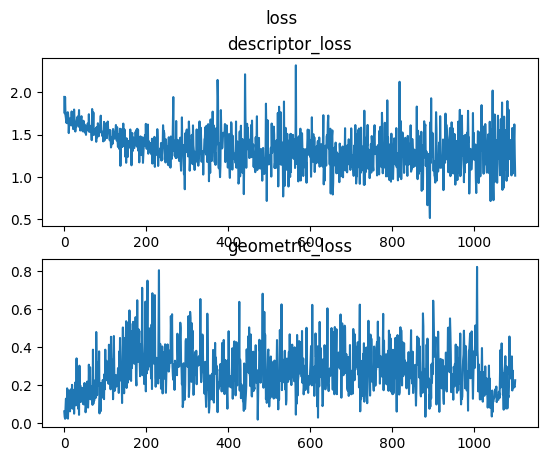

In [12]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('loss')
ax1.set_title('descriptor_loss')
ax2.set_title('geometric_loss')
ax1.plot(descriptor_loss_list)
ax2.plot(geometric_loss_list)

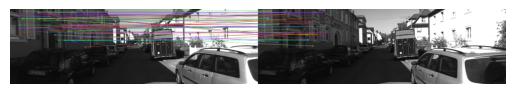

In [15]:
kp_net.eval()

with torch.no_grad():
  kp_1, d_1, kp_prob1 = kp_net(move_to_gpu(input1))
  kp_2, d_2, kp_prob2 = kp_net(move_to_gpu(input2))

kp_1, d_1 = filter_and_pad_points(kp_prob1, kp_1, d_1, 0.005)
kp_2, d_2 = filter_and_pad_points(kp_prob2, kp_2, d_2, 0.005)

infer_keypoints1 = kp_1.detach().cpu().numpy()
infer_keypoints2 = kp_2.detach().cpu().numpy()


def convert_keypoints(keypoints_array, size=1.0):
    """Converts numpy array keypoints to a list of cv2.KeyPoint objects."""
    return [cv2.KeyPoint(x=float(kp[0]), y=float(kp[1]), size=size) for kp in keypoints_array.reshape(-1, 2)]

# Convert numpy array keypoints to list of cv2.KeyPoint objects
keypoints1 = convert_keypoints(infer_keypoints1)
keypoints2 = convert_keypoints(infer_keypoints2)

# Create a BFMatcher object
# Choose the appropriate norm type depending on your descriptor
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match descriptors
matches = bf.match( tensor_to_numpy(d_1).reshape(-1, 256), tensor_to_numpy(d_2).reshape(-1, 256))

# Apply Lowe's ratio test
ratio_threshold = 0.75  # Can be adjusted, common values are in the range 0.7 to 0.8
# good_matches = [m for m, n in matches if m.distance < ratio_threshold * n.distance]

# Draw the top N matches
img_matches = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches, None, flags=2)

# Display the result
# Display the image
plt.imshow(img_matches)
plt.axis('off')  # Turn off axis numbers
plt.show()
